# UTS PEMBELAJARAN MESIN 2024 (Klasifikasi Neural Network (NN) Pada Data Citra)
***
## Anggota Kelompok:
### Diantoro Kadarman   / 2241720084
### Febby Mathelda S M  / 2241720067
### Habibatul Mustofa   / 2241720211
### Maya Melanesia R    / 2241720237
***
# Intro

Pada UTS ini, Anda diminta untuk melakukan klasifikasi citra wajah dengan menggunakan dataset Casia-Webface (Data dapat diunduh pada Kaggle).
Anda diperbolehkan melakukan eksplorasi terhadap:
1. Metode pra pengolahan
2. Pemilihan fitur
3. Arsitektur ANN
4. Fungsi Aktiviasi
5. Metric Evaluasi

# Preparation & Import Library

In [44]:
import os
import glob
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

# Load Data

In [6]:
# Upload file kaggle.json dari lokal Anda terlebih dahulu
from google.colab import files
files.upload()  # Upload file `kaggle.json`

# Membuat direktori .kaggle dan memindahkan file API ke sana
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Menyesuaikan permission
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [7]:
# Install library kaggle jika belum tersedia
!pip install kaggle

# Mengunduh dataset CASIA-Webface
!kaggle datasets download -d ntl0601/casia-webface --unzip -p /content

Dataset URL: https://www.kaggle.com/datasets/ntl0601/casia-webface
License(s): unknown
... resuming from 0 bytes (2720283721 bytes left) ...
100% 2.53G/2.53G [01:56<00:00, 27.0MB/s]
100% 2.53G/2.53G [01:56<00:00, 23.4MB/s]


In [45]:
# Path ke folder yang berisi data yang diunduh
path = "/content/casia-webface"

# Melihat folder di dalam dataset
files = os.listdir(path)

print("Path to dataset files:", path)
print("Number of folders:", len(files))
print("First folders:", files[:5])
print("Last folders:", files[-5:])

Path to dataset files: /content/casia-webface
Number of folders: 10572
First folders: ['001163', '006388', '002782', '000043', '002453']
Last folders: ['009913', '002661', '008534', '003216', '010180']


Found 490623 images.


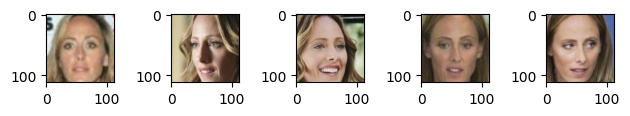

In [46]:
path = "/content/casia-webface"

# Find all image files in the dataset (assuming images are in .jpg format)
image_files = glob.glob(os.path.join(path, "**/*.jpg"), recursive=True)

# Check if any images were found
if image_files:
    print(f"Found {len(image_files)} images.")

    # Display the first 5 images
    for i, image_file in enumerate(image_files[:5]):
        img = Image.open(image_file)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.tight_layout()
        # plt.axis('off')

    plt.show()
else:
    print("No images found in the dataset.")

# Preprocessing

In [47]:
data_path = "/content/casia-webface"

# Inisialisasi dictionary untuk menyimpan file gambar per kelas
class_files = {}

# Membaca folder dalam path dan mengelompokkan file gambar per kelas
for class_dir in os.listdir(data_path):
    class_path = os.path.join(data_path, class_dir)
    if os.path.isdir(class_path):  # Hanya membaca folder
        image_files = glob.glob(os.path.join(class_path, "*.jpg"))  # Sesuaikan dengan ekstensi file gambar
        class_files[class_dir] = image_files

# Inisialisasi list kosong untuk data train dan test
train_files = []
test_files = []

# Pembagian data train dan test untuk setiap kelas
for class_dir, image_files in class_files.items():
    train, test = train_test_split(image_files, test_size=0.2, random_state=42)
    train_files.extend(train)
    test_files.extend(test)

print(f"Number of training files: {len(train_files)}")
print(f"Number of testing files: {len(test_files)}")

Number of training files: 388297
Number of testing files: 102326


In [48]:
# Path dataset
data_path = '/content/casia-webface'

# Data Augmentation untuk mengurangi penggunaan memori saat proses pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Membuat generator data langsung dari direktori
train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=(64, 64),  # Mengubah ukuran input gambar
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42
)

# Menentukan jumlah kelas berdasarkan data di generator
num_classes = train_generator.num_classes

# Menampilkan hasil pelatihan
print(f"Processed training data shape: {train_generator.samples} images")
print(f"Processed validation data shape: {validation_generator.samples} images")
print(f"Number of classes: {num_classes}")

Found 396673 images belonging to 10572 classes.
Found 93950 images belonging to 10572 classes.
Processed training data shape: 396673 images
Processed validation data shape: 93950 images
Number of classes: 10572


**Encoding Label**: LabelEncoder digunakan untuk mengonversi label kelas ke bentuk numerik. Kemudian, label dikonversi ke format one-hot encoding menggunakan to_categorical agar sesuai dengan output klasifikasi multi-kelas.

# Build Model

In [ ]:
# Membangun model CNN yang lebih efisien dengan GlobalAveragePooling
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Mengompilasi model dengan learning rate yang diatur
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callback untuk early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Melatih model dengan generator
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/10
  105/12396 ━━━━━━━━━━━━━━━━━━━━ 1:18:17 382ms/step - accuracy: 3.2342e-04 - loss: 9.2798

**Arsitektur CNN**: Model CNN dengan beberapa lapisan konvolusi, pooling, batch normalization, dan dropout untuk mencegah overfitting. Fungsi aktivasi ReLU digunakan dalam lapisan konvolusi dan dense, sementara softmax digunakan pada lapisan output.


**Kompilasi Model**: Optimizer Adam dengan fungsi loss categorical cross-entropy digunakan, dan metrik akurasi dipilih untuk evaluasi.

# Evaluation

**Evaluasi Model**: classification_report menghasilkan metrik evaluasi, termasuk presisi, recall, F1-score, dan akurasi untuk setiap kelas.

In [ ]:
# Evaluasi model
y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Mengambil label dari validasi
y_test_classes = validation_generator.classes

# Mengambil nama kelas dari generator
class_labels = list(validation_generator.class_indices.keys())

# Menampilkan laporan klasifikasi
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=class_labels))

# Visualisasi Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Visualisasi Akurasi dan Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()